In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../util')

from curvature import *

In [2]:
#Import simulation
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/' #Path for Daint

In [3]:
#Read Data
#d2D = xr.open_mfdataset(path+'output/lfff????????.nc', combine='by_coords')
d2D = xr.open_mfdataset(path+'output/lfff[2,3]???0000.nc', combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [4]:
#Mask of all moist regions
bFMSE = np.where(d2D.FMSE > np.median(d2D.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)

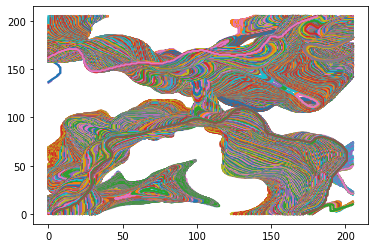

In [5]:
for t in range(len(bFMSE)):
    
    contours = get_contours(bFMSE[t,:,:])
    
    for n, contour in enumerate(contours):
         plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [11]:
def distance_contour_extremas(FMSE, FMSE_told, dx = 1):

    #Create list of curvature extrema at old timestep
    contours_last = get_contours(FMSE_told)
    

    x_old = np.array([], int)
    y_old = np.array([], int)
    extremas_old = np.array([], int)
    
    for n, contour in enumerate(contours_last):
        x = contour[:, 1]
        y = contour[:, 0]
                
        cx, cy, curv = calc_curv(x, y, dx=dx)

        extrema, ex, ey = get_extrema(curv, cx, cy)

        x_old = np.append(x_old, ex)
        y_old = np.append(y_old, ey)
        extremas_old = np.append(extremas_old, extrema)

  
    #Create list of curvature extrema at new timestep
    contours = get_contours(FMSE)
    x = np.array([], int)
    y = np.array([], int)
    extremas = np.array([], int)
    
    for n, contour in enumerate(contours):
        cx, cy, curv = calc_curv(contour[:, 1], contour[:, 0], dx = dx)
        extrema, ex, ey = get_extrema(curv, cx, cy)
        
        x = np.append(x, ex)
        y = np.append(y, ey)
        extremas = np.append(extremas, extrema)
        
    #Search for the closest matching point
    x_new = np.array([], int)
    y_new = np.array([], int)
    extremas_new = np.array([], int)
    x_corr = np.array([], int)
    y_corr = np.array([], int)
    distances = np.array([], int)

    for n in range(len(x)):
        distance = np.sqrt((x_old-x[n])**2 + (y_old-y[n])**2) #Distance between all the points

        if 1 <= np.min(distance): #Only consider points that move
            if 0.0 != extremas[n]: #Only consider points that are curved
            
                #All the point at t, that fulfill the criterion
                x_new = np.append(x_new, x[n])
                y_new = np.append(y_new, y[n])
                extremas_new = np.append(extremas_new , extremas[n])
            
                #Coordinates and distance to closest point
                x_corr = np.append(x_corr, x_old[np.argmin(distance)])
                y_corr = np.append(y_corr, y_old[np.argmin(distance)])
                distances=np.append(distances, np.min(distance))
    
    #Return the values of the extrema their coordinates and the distance between them
    return  extremas_new, x_new, y_new, x_corr, y_corr, distances * dx

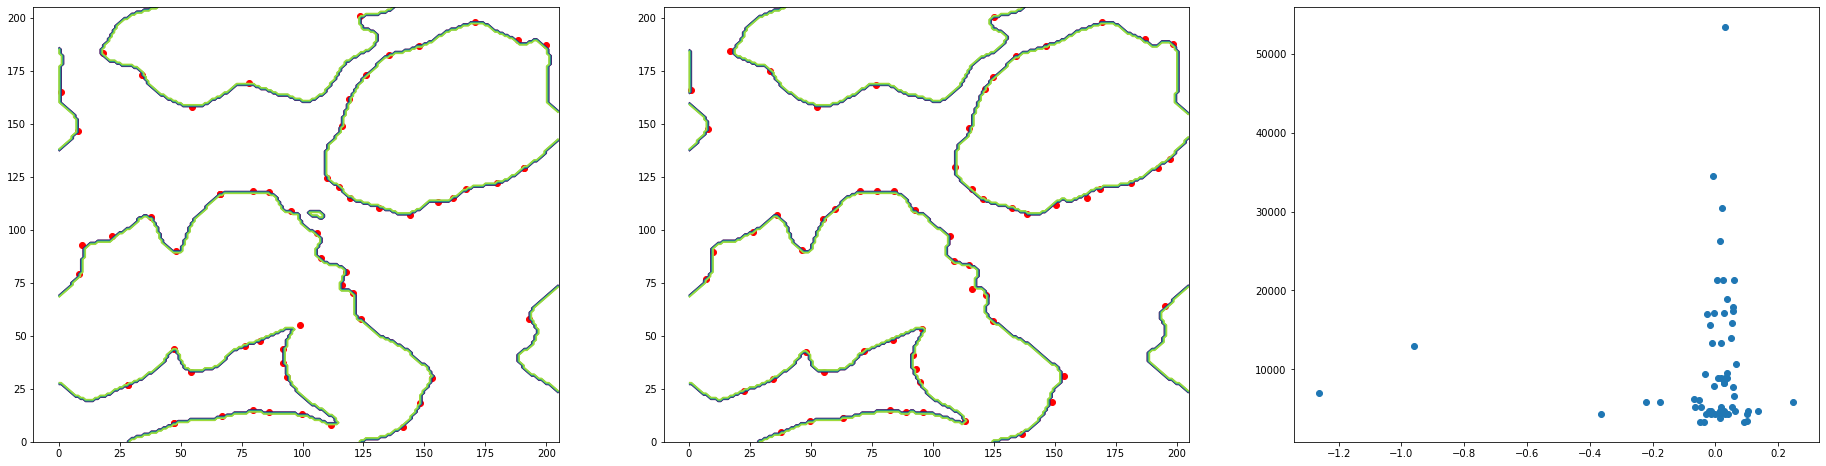

In [13]:
curvature, x, y, x_old, y_old, distance,  = distance_contour_extremas(bFMSE[1,:,:], bFMSE[0,:,:], dx=3300 ) 


fig = plt.figure(figsize=(32,8))

plt.subplot(1, 3, 1)
plt.contour(bFMSE[1,:,:])
plt.scatter(x_old,y_old, c = 'r')

#for en, extrem in enumerate(curvature):
#    circle = plt.Circle((x[en], y[en]), radius = 100 * curvature, facecolor='none', edgecolor='k')
#    ax.add_patch(circle)

plt.subplot(1, 3, 2)
plt.contour(bFMSE[2,:,:])
plt.scatter(x, y, c = 'r')

plt.subplot(1, 3, 3)
plt.scatter( curvature, distance)

curvature = np.array([], float)
distance  = np.array([], float)

for t in range(1,len(bFMSE)):
    curv, x, y, x_old, y_old, dist,  = distance_contour_extremas(bFMSE[t,:,:], bFMSE[t-1,:,:],  dx=3300)
    curvature = np.append(curvature, curv)
    distance = np.append(distance, dist)

(0, 250)

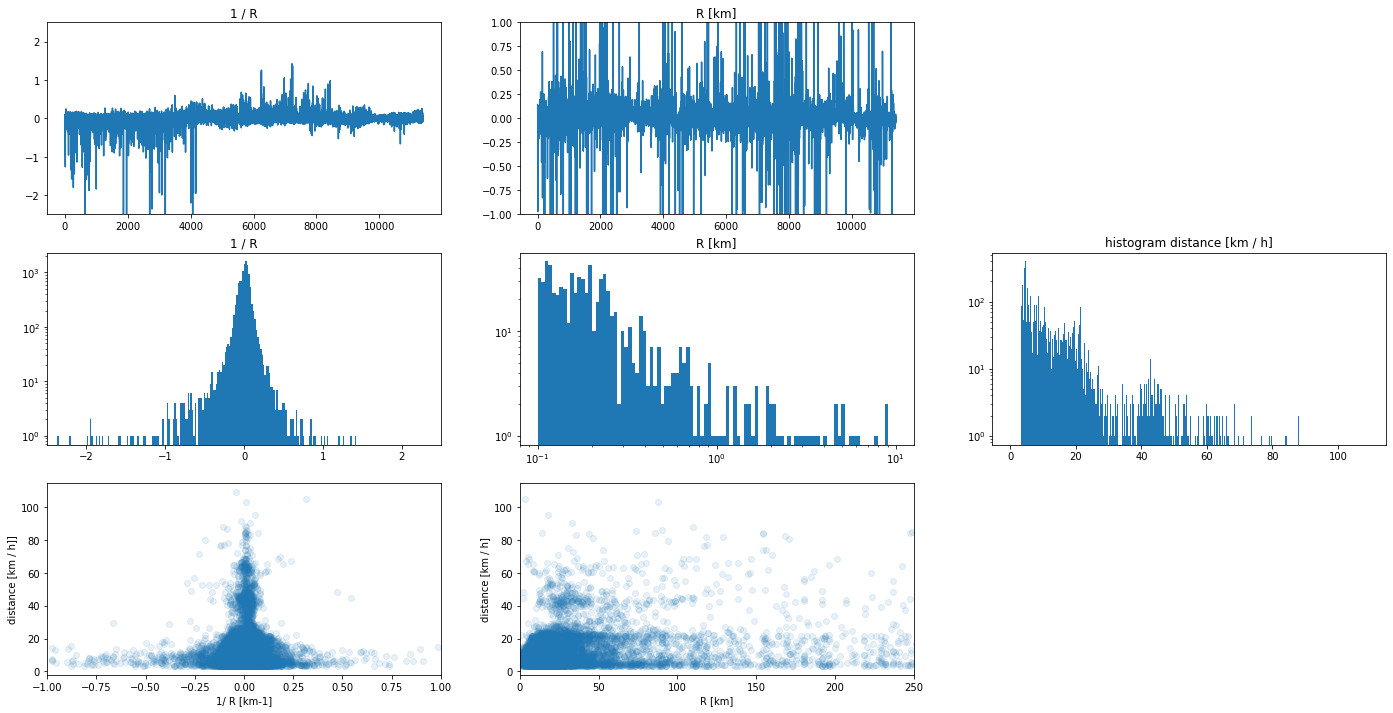

In [39]:
fig = plt.figure(figsize=(24,12))

plt.subplot(3, 3, 1)
plt.plot(curvature)
plt.title('1 / R')
plt.ylim(-2.5,2.5)

plt.subplot(3, 3, 2)
plt.plot(1 / curvature / 1000)
plt.title('R [km]')
plt.ylim(-1, 1)

plt.subplot(3, 3, 4)
plt.hist(curvature, bins=1000)
plt.yscale('log')
plt.xlim(-2.5,2.5)
plt.title('1 / R')

plt.subplot(3, 3, 5)
plt.hist(1 / curvature / 1000, bins=np.logspace(np.log10(0.1),np.log10(10.0), 100))
plt.yscale('log')
plt.xscale('log')
#plt.xlim(-10000,10000)
plt.title('R [km]')

plt.subplot(3, 3, 6)
plt.hist(distance / 1000, bins=np.arange(0,np.amax(distance / 1000), 0.1 ))
plt.title('histogram distance [km / h]')
plt.yscale('log')


plt.subplot(3, 3, 7)
plt.scatter(curvature, distance / 1000, alpha=0.1)
plt.xlabel('1/ R [km-1]' )
plt.ylabel('distance [km / h]]')
plt.xlim(-1, 1)

plt.subplot(3, 3, 8)
plt.scatter(1 / curvature, distance / 1000, alpha=0.1)
plt.xlabel('R [km]')
plt.ylabel('distance [km / h]')
plt.xlim(0, 250)



ValueError: num must be 1 <= num <= 12, not 13

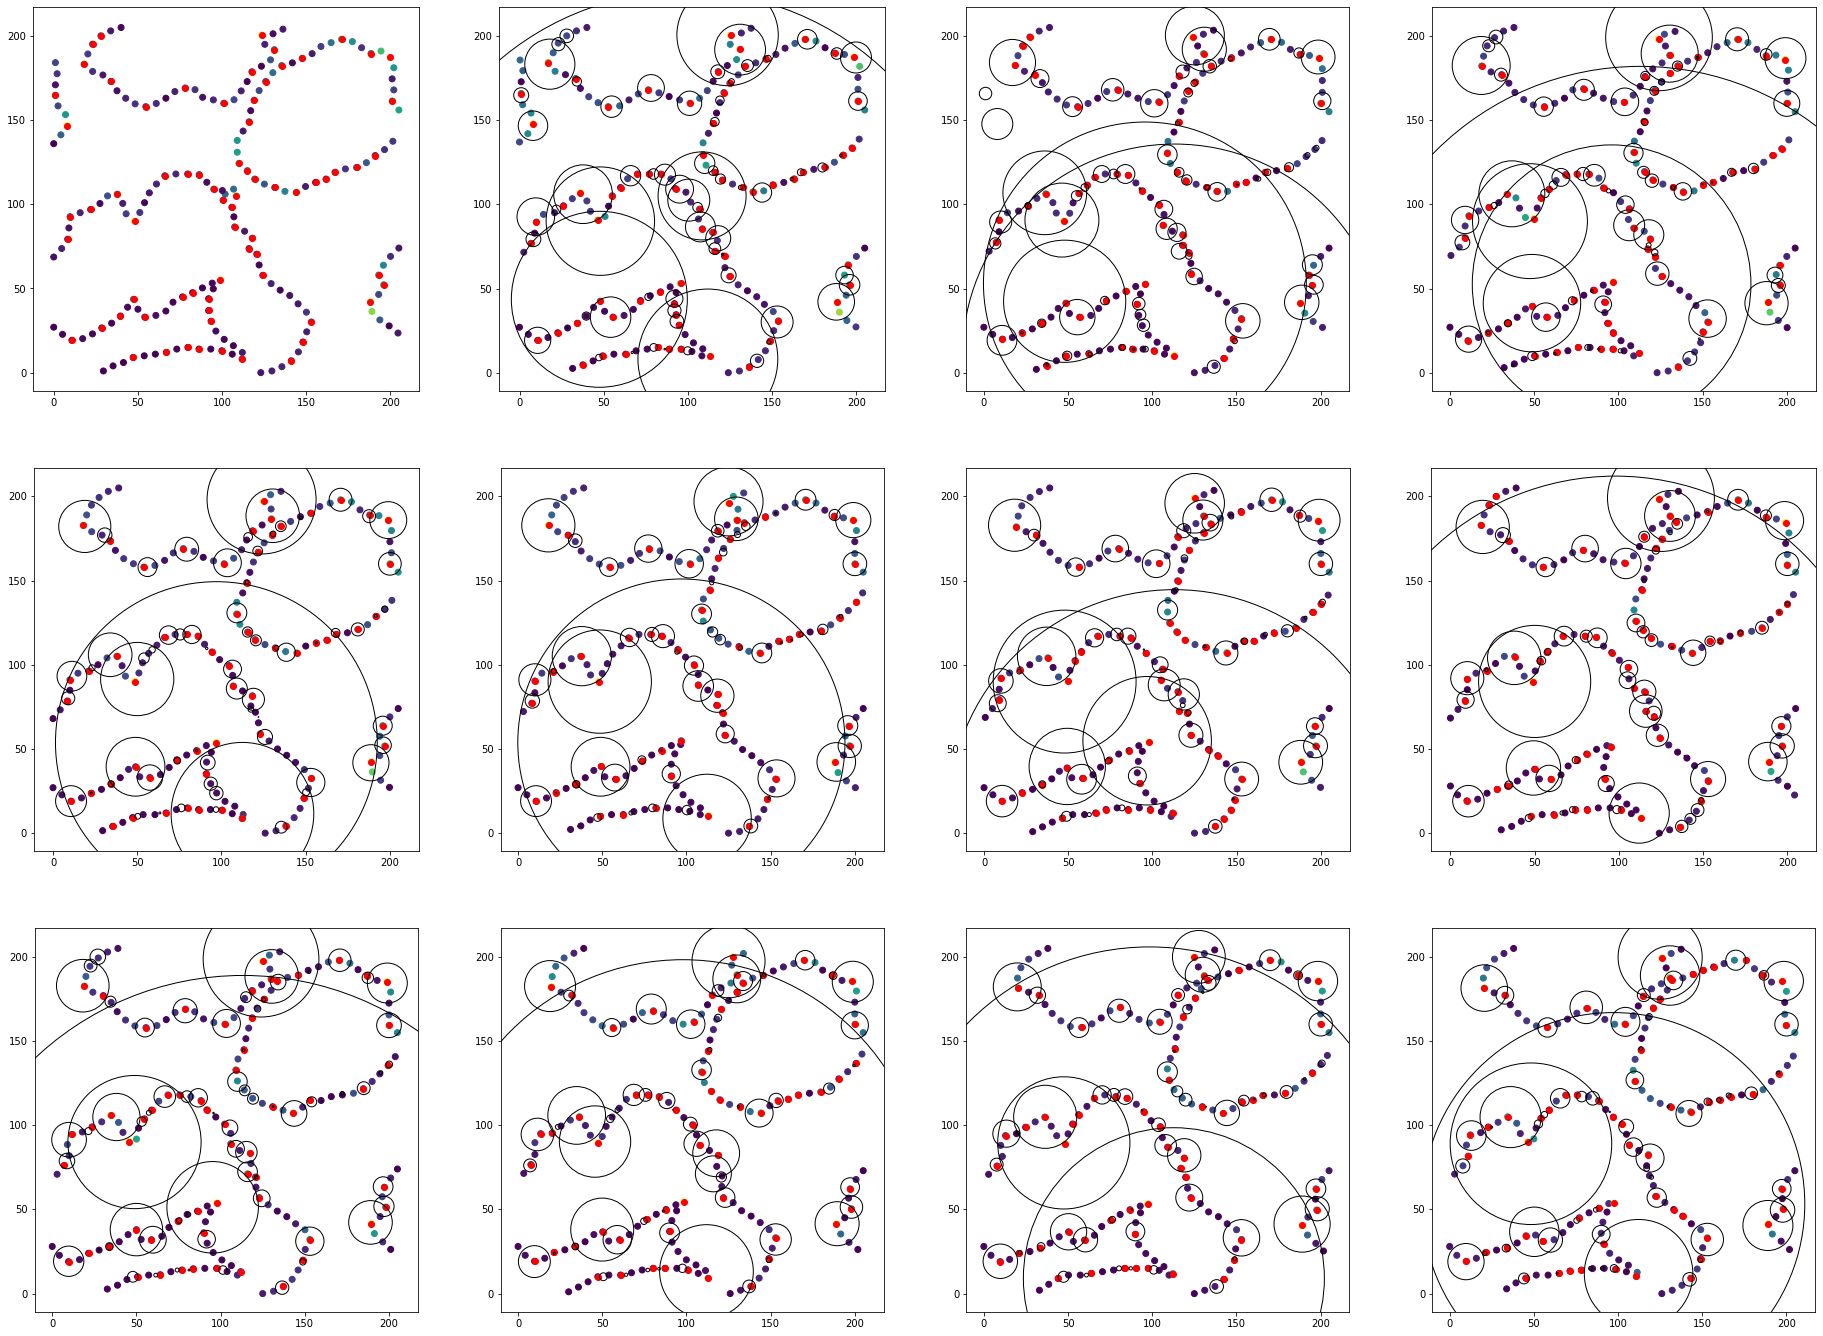

In [9]:
### Plot curvature and local extrema for all contours

fig = plt.figure(figsize=(32,24))
for t in range(len(bFMSE)):
    ax = fig.add_subplot(3,4,t+1)
    ax.set_aspect('equal')

    contours = get_contours(bFMSE[t,:,:])
    contours_last = get_contours(bFMSE[t-1,:,:])

    for n, contour in enumerate(contours):

        #Compute curvature
        x = contour[:, 1]
        y = contour[:, 0]
        xn, yn, curv= calc_curv(x, y)

        #Plot curvature
        ax.scatter(xn, yn, c = np.abs(curv))
    
        #Plot Extrema
        extrema, ex, ey = get_extrema(curv, xn, yn) #Todo: replace by x ,y
        ax.scatter(ex, ey, c = 'r')
    
    #Add circles of extremas of last timestep
    if t > 0:
        for n, contour in enumerate(contours_last):
            cx, cy, curv = calc_curv(contour[:, 1], contour[:, 0])
            extrema, ex, ey= get_extrema(curv, cx, cy)
                
            for en, extrem in enumerate(extrema):
                circle = plt.Circle((ex[en], ey[en]), radius = 100 * extrem, facecolor='none', edgecolor='k')
                ax.add_patch(circle)
              